In [ ]:
import time
import numpy as np

class Airport:
    def __init__(self, iden=None, name=None):
        self.code = iden
        self.name = name
        self.routes = []
        self.routeHash = dict()
        self.outweight = 0
        self.pageIndex = 0

    def __repr__(self):
        return f"{self.code}\t{self.outweight}\t{self.name}"

    def add_destination(self, destination_airport, weight=1):
        if destination_airport.code in self.routeHash:
            self.routeHash[destination_airport.code] += weight
        else:
            self.routes.append(destination_airport)
            self.routeHash[destination_airport.code] = weight

        self.outweight += weight


edgesHash = dict()
airportList = []
airportHash = dict()

def readAirports(fd):
    print("Reading Airport file from {0}".format(fd))
    airportsTxt = open(fd, "r", encoding="utf-8")
    cont = 0
    for line in airportsTxt.readlines():
        a = Airport()
        try:
            temp = line.split(',')
            if len(temp[4]) != 5:
                raise Exception('not an IATA code')
            
            code = temp[4][1:-1]
            # check for valid codes
            if len(code) == 3 and code.isalpha():
                a.code = code
                a.name = temp[1][1:-1] + ", " + temp[3][1:-1]
                cont += 1
                airportList.append(a)
                airportHash[a.code] = a
            else:
                pass

        except Exception:
            pass

    airportsTxt.close()
    print(f"There were {cont} Airports with IATA code")

def readRoutes(fd):
    print(f"Reading Routes file from {fd}")
    routesTxt = open(fd, "r", encoding="utf-8")
    missing_IATA_code = {"origin": [], "destination": []}
    for line in routesTxt.readlines():
        try:
            temp = line.split(',')
            origin = temp[2]
            destination = temp[4]

            if len(origin) == 3 and origin.isalpha() and len(destination) == 3 and destination.isalpha():
                if origin not in airportHash:
                    missing_IATA_code["origin"].append(destination)
                    new_airport = Airport(origin, "NaN")
                    airportHash[origin] = new_airport
                    airportList.append(new_airport)
                elif destination not in airportHash:
                    missing_IATA_code["destination"].append(origin)
                    new_airport = Airport(destination, "NaN")
                    airportHash[destination] = new_airport
                    airportList.append(new_airport)

                airportHash[origin].add_destination(airportHash[destination])
        except Exception:
            pass

    print(f"Sink nodes: {len(missing_IATA_code['origin'])} for origin and {len(missing_IATA_code['destination'])} destination")

def computePageRanks(airports_list, airport_hash, epsilon=1e-4, L=0.85, max_iter=100):
    n = len(airports_list)
    
    # Initialize PageRank using uniform distributions
    P = np.ones(n) / n
    teleport = (1 - L) / n    

    # Iterate until convergence or max iterations
    for iteration in range(max_iter):  
        # Compute new PageRank vector Q
        Q = np.zeros(n)

        # check contribution of sink nodes
        sink_contrib = sum(P[j] for j, a in enumerate(airports_list) if a.outweight == 0) / n

        # For each airport, calculate the contribution to its inbound neighbors
        for j, airport in enumerate(airports_list):
            if airport.outweight > 0:
                # Distribute the current PageRank value of airport j to its destination airports
                for dest_code, weight in airport.routeHash.items():
                    dest_index = airports_list.index(airport_hash[dest_code])
                    Q[dest_index] += L * P[j] * (weight / airport.outweight)
        
        # Add sink contributions and teleportation
        Q += sink_contrib + teleport

        # Normalize the new PageRank vector (this ensures the sum of all ranks is 1)

        # Check for convergence
        if np.linalg.norm(Q - P, 1) < epsilon:
            print(f"Converged after {iteration + 1} iterations")
            break
        P = Q
    return P

def outputPageRanks(weights, airports_list, output_filename):
    with open(output_filename, 'w', encoding='utf-8') as file:
        sorted_list = sorted([(rank, airport.name) for rank, airport in zip(weights, airports_list)], reverse=True)
        for rank, name in sorted_list:
            file.write(f"{rank:.10f}\t{name}\n")

#### Execute in main ####
readAirports('airports.txt')
readRoutes('routes.txt')

times = {}
L_list = np.arange(0, 1.05, 0.05)

for L in L_list:
    # Update weights for each airport so that they are constant
    time1 = time.time()
    for airport in airportList:
        airport.pageIndex = 1/len(airportList)

    weights = computePageRanks(airportList, airportHash, L)

    time2 = time.time()
    times[L] = time2 - time1
    print(f"Computation time: {round(time2 - time1, 3)} s")
    #outputPageRanks(weights, airportList, output_filename = "sorted_weights.txt")

Reading Airport file from airports.txt
There were 5629 Airports with IATA code
Reading Routes file from routes.txt
Sink nodes: 69 for origin and 78 destination
Computation time: 163.659 s
Converged after 5 iterations
Computation time: 8.127 s
Converged after 4 iterations
Computation time: 6.695 s


KeyboardInterrupt: 

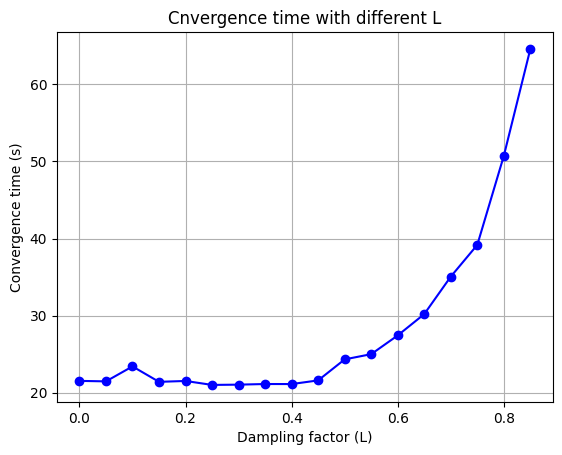

In [11]:
import matplotlib.pyplot as plt

# Convert the dictionary keys and values to lists
time = list(times.keys())  # x-axis (time or sequential steps)
values = list(times.values())  # y-axis (values at those times)

# Plotting the time series
plt.plot(time, values, marker='o', linestyle='-', color='b')  # Use 'o' for data points
plt.xlabel('Dampling factor (L)')  
plt.ylabel('Convergence time (s)')  
plt.title('Cnvergence time with different L')  
plt.grid(True)  # Show grid
plt.show()  # Display the plot
    